In [205]:
import qiskit.tools.jupyter
%qiskit_version_table

In [206]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
import pytest

from qiskit import IBMQ, Aer, assemble, transpile, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info.operators import Operator
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PhaseOracle
from qiskit.algorithms import Grover, AmplificationProblem

# Quantum Circuit Init

## Oracles

In [ ]:
def binary_sudoku_2x2(qc, clause_list, clause_qubits):
    def XOR(qc, a, b, out):
        qc.cx(a, out)
        qc.cx(b, out)
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    qc.mct(clause_qubits, out_qubit)
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

In [3]:
# TODO: make it so it actualy makes an oracle
# Takes an n x d nonogram and converts it into an nd x nd diagonal matrix with -1 being black and 1 being white
# Limitations: spits answer back out, only one "solution" results 
def cheat(solution):
    return Operator(np.diag(list(map(lambda x: -1 if x == '1' else 1, solution))))

In [53]:
def boolean_phase_oracle(row_clues, col_clues, n, d = None, debug_mode = False):
    if d is None:
        d = n
    boolean_statement = ""
    r_v, c_v = var_clauses(n, d)
    
    for r_idx, r_clue in enumerate(row_clues):
        bit_strings = possible_d[f"{n}/{';'.join(map(str, r_clue))};"]
        clauses = []
        for b_idx, bitstring in enumerate(bit_strings):
            clause = ""
            for c_idx in range(d):
                if bitstring & (1 << c_idx):
                    clause += f'v{r_v[r_idx][c_idx]}&'
                else:
                    clause += f'~v{r_v[r_idx][c_idx]}&'
            clauses.append("(" + clause[:-1] + ")")
        boolean_statement += "(" + "|".join(clauses) + ")&"
        
 # iterate over column clues (same as with row clues, but with transposed variables)
    for c_idx, c_clue in enumerate(col_clues):
        bitstrings = possible_d[f"{d}/{';'.join(map(str, c_clue))};"]
        clauses = []
        for b_idx, bitstring in enumerate(bitstrings):
            clause = ""
            for r_idx in range(n):
                if bitstring & (1 << r_idx):
                    clause += f"v{r_v[r_idx][c_idx]}&"
                else:
                    clause += f"~v{r_v[r_idx][c_idx]}&"
            clauses.append("(" + clause[:-1] + ")")
        boolean_statement += "(" + "|".join(clauses) + ")&"
 
    # remove trailing "&"
    boolean_statement = boolean_statement[:-1]
    return PhaseOracle(boolean_statement) if not debug_mode else boolean_statement
 

In [ ]:
boolean_phase_oracle([(1,),(1,)],[(1,),(1,)],2)

In [ ]:
def G(n_qubits

In [128]:
def Hxn(n_qubits):
    sub_q = QuantumRegister(n_qubits)
    sub_circ = QuantumCircuit(sub_q, name='Hxn')
    sub_circ.h(sub_q)
    return sub_circ.to_instruction()

In [203]:
def diffusion(n, debug=False):
    c = QuantumCircuit(n, name="Diffuser/Amplifier")
    HXN = Hxn(n)
    q = c.qubits
    c.append(HXN, q)
    c.x(q)
    c.barrier()
    c.h(q[-1]) # ?
    c.mct(list(range(n-1)), q[-1])
    c.h(q[-1])
    c.x(q)
    c.append(HXN, q)
    c.z(q[:-1])
    c.h(q[:-1])
    return c.to_instruction() if not debug else c.draw()
#     for q in range(nq):
#         qc.h(q)
#     for q in range(nq):
#         qc.x(q)
#     qc.h(nq-1)
#     qc.mct(list(range(nq-1)), nq-1)
#     qc.h(nq-1)
#     for q in range(nq):
#         qc.x(q)
#     for q in range(nq):
#         qc.h(q)
#     U = qc.to_gate()
#     U.name = "U$_s"
#     return U
QC = QuantumCircuit(3)
diffusion(3, True)
# D = diffusion(3)
# QCD = QC.decompose() # Does not modify original circuit
# QC.append(D, QC.qubits)

┌──────┐┌───┐          ┌───┐     ┌──────┐┌───┐┌───┐
q_0: ┤0     ├┤ X ├───────■──┤ X ├─────┤0     ├┤ Z ├┤ H ├
     │      │├───┤       │  ├───┤     │      │├───┤├───┤
q_1: ┤1 Hxn ├┤ X ├───────■──┤ X ├─────┤1 Hxn ├┤ Z ├┤ H ├
     │      │├───┤┌───┐┌─┴─┐├───┤┌───┐│      │└───┘└───┘
q_2: ┤2     ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤2     ├──────────
     └──────┘└───┘└───┘└───┘└───┘└───┘└──────┘

In [115]:
def simple(target, num_qubits = 2):
    # if target not in Target:
    #     return -1
    if (num_qubits == None):
        num_qubits = math.ceil(math.sqrt(target))
    q_reg = QuantumRegister(num_qubits, 'q')
    o_reg = QuantumRegister(1, 'o')
    qc = QuantumCircuit(q_reg, o_reg, name='Simple Oracle')
    b = np.binary_repr(target, width=2)
    for index, bit in enumerate(b):
        if bit == '0':
            qc.x(index)
    qc.ccx(q_reg[0], q_reg[1], o_reg[0])
    for index, bit in enumerate(b):
        if bit == '0':
            qc.x(index)
    return qc.to_instruction()
simple(0)

Instruction(name='Simple Oracle', num_qubits=3, num_clbits=0, params=[])

# Nonogram Setup

## Possible nonogram descriptions

In [207]:
possible_d = {
    # l = 1
    "1/0;" : [0b0],
    "1/1;" : [0b1],
        
    # l = 2
    "2/0;" : [0b00],
    "2/1;" : [0b01,0b10],
    "2/2;" : [0b11],
    
    # l = 3
    "3/0;" : [0b000],
    "3/1;" : [0b100, 0b010,0b001],
    "3/2;" : [0b110,0b011],
    "3/3;" : [0b111],
    "3/1;1;" : [0b101],
    
    # l = 4
    "4/0;" : [0b0000],
    "4/1;" : [0b1000,0b0100, 0b0010,0b0001],
    "4/2;" : [0b1100,0b0110,0b0011],
    "4/3;" : [0b1110,0b0111],
    "4/4;" : [0b1111],
    "4/1;1;" : [0b1010,0b0101,0b1001],
    "4/2;1;" : [0b1101],
    "4/1;2;" : [0b1011],
              
    # l = 5
    "5/0;" : [0b00000],
    "5/1;" : [0b10000,0b01000,0b00100,0b00010,0b00001],
    "5/2;" : [0b11000,0b01100,0b00110, 0b00011],
    "5/3;" : [0b11100,0b01110,0b00111],
    "5/4;" : [0b11110,0b01111],
    "5/5;" : [0b11111],
    "5/1;1;" : [0b10100,0b10010,0b10001,0b01010,0b01001,0b00101],
    "5/1;2;" : [0b10011,0b10110,0b01011],
    "5/1;3;" : [0b10111],
    "5/2;1;" : [0b11001,0b11010,0b01101,],
    "5/2;2;" : [0b11011],
    "5/3;1;" : [0b11101],
    "5/1;1;1;" : [0b10101],
}
def var_clauses(n, d=None):
    if d is None:
        d = n
    X = np.arange(n*d).reshape((n,d))
    col_vars = []
    row_vars = []
    for row in range(n):
        row_vars.append(list(X[row, :]))
    for col in range(d):
        col_vars.append(list(X[:, col]))
    return row_vars, col_vars

In [208]:
# def generate_bitstrings(clue):
#     n, clue_str = clue.split('/')
#     n = int(n)
#     clue_list = list(map(int, clue_str.split(';')))
#     if not clue_list[-1]:
#         clue_list.pop()
#     def generate_bitstrings_helper(n, clue_list):
#         if not clue_list:
#             return ['0' * n]
#         if n < sum(clue_list) + len(clue_list) - 1:
#             return []
#         first, *rest = clue_list
#         prefix = '0' * first + '1'
#         return [prefix + suffix for suffix in generate_bitstrings_helper(n - len(prefix), rest)] + generate_bitstrings_helper(n - 1, clue_list)
#     return generate_bitstrings_helper(n, clue_list)

# def generate_bitstrings(clue):
#     n, clue_str = clue.split('/')
#     n = int(n)
#     clue_list = list(map(int, filter(lambda x: x, clue_str.split(';'))))
#     def generate_bitstrings_helper(n, clue_list):
#         if not clue_list:
#             return ['0' * n]
#         if n < sum(clue_list) + len(clue_list) - 1:
#             return []
#         first, *rest = clue_list
#         prefix = '0' * first + '1'
#         return [prefix + suffix for suffix in generate_bitstrings_helper(n - len(prefix), rest)] + generate_bitstrings_helper(n - 1, clue_list)
#     return generate_bitstrings_helper(n, clue_list)

def generate_bitstrings(clue):
    n, clue_str = clue.split('/')
    n = int(n)
    clue_list = list(map(int, filter(lambda x: x, clue_str.split(';'))))
    def generate_bitstrings_helper(n, clue_list):
        if not clue_list:
            return ['0' * n]
        if n < sum(clue_list) + len(clue_list) - 1:
            return []
        first, *rest = clue_list
        prefix = '1' * first
        if rest:
            prefix += '0'
        return [prefix + suffix for suffix in generate_bitstrings_helper(n - len(prefix), rest)] + (['0' + suffix for suffix in generate_bitstrings_helper(n - 1, clue_list)] if clue_list else [])
    return generate_bitstrings_helper(n, clue_list)

# def generate_clues(n):
#     def generate_clues_helper(n):
#         if n == 0:
#             return [[]]
#         return [[first] + rest for first in range(n + 1) for rest in generate_clues_helper(n - first)]
#     return ['/'.join([str(n)] + [';'.join(map(str, clue))]) for clue in generate_clues_helper(n)]
# def generate_clues(n):
#     def generate_clues_helper(n):
#         if n == 0:
#             return [[]]
#         return [[first] + rest for first in range(1, n + 1) for rest in generate_clues_helper(n - first)]
#     return ['/'.join([str(n)] + [';'.join(map(str, clue))]) for clue in generate_clues_helper(n)]

# def generate_clues(n):
#     def generate_clues_helper(n):
#         if n == 0:
#             return [[]]
#         return [[first] + rest for first in range(1, n + 1) for rest in generate_clues_helper(n - first - 1)]
#     return ['/'.join([str(n)] + [';'.join(map(str, clue)) + ';']) for clue in generate_clues_helper(n)]


# def generate_clues(n):
#     def generate_clues_helper(n):
#         if n == 0:
#             return [[]]
#         return [[first] + rest for first in range(n + 1) for rest in generate_clues_helper(n - first - (1 if first > 0 else 0))]
#     return ['/'.join([str(n)] + [';'.join(map(str, clue)) + (';' if clue else '')]) for clue in generate_clues_helper(n)]

# def generate_clues(n):
#     clues = [[]]
#     for i in range(n):
#         new_clues = []
#         for clue in clues:
#             new_clues.extend([clue + [first] for first in range(n + 1 - sum(clue) - len(clue) * (1 if clue else 0))])
#         clues = new_clues
#     return ['/'.join([str(n)] + [';'.join(map(str, clue)) + (';' if clue else '')]) for clue in clues]

# def generate_clues(n):
#     def generate_clues_helper(n):
#         if n == 0:
#             return [[]]
#         return [[first] + rest for first in range(n + 1) for rest in generate_clues_helper(n - first - (1 if first > 0 else 0))]
#     return ['/'.join([str(n)] + [';'.join(map(str, clue)) + (';' if clue else '')]) for clue in generate_clues_helper(n) if len(clue) == 1 or clue[0] > 0]

def generate_clues(n):
    clues = [[]]
    for i in range(n):
        new_clues = []
        for clue in clues:
            new_clues.extend([clue + [first] for first in range(n + 1 - sum(clue) - len(clue) * (1 if clue else 0))])
        clues = new_clues
    return ['/'.join([str(n)] + [';'.join(map(str, clue)) + (';' if clue else '')]) for clue in clues if len(clue) == 1 or clue[0] > 0]

# def generate_clues(n):
#     def generate_clues_helper(n):
#         if n == 0:
#             return [[]]
#         return [[first] + rest for first in range(1, n + 1) for rest in generate_clues_helper(n - first)]
#     return ['/'.join([str(n)] + [';'.join(map(str, clue))]) for clue in generate_clues_helper(n)]

In [37]:
for clue in generate_clues(n=3):
    print(clue)

3/1;0;0;


In [ ]:
def to_regex(d, l):
    regex = None
    num_clues = len(d)
    if num_clues == 0:
        regex = f'0{{{l}}}'
    elif num_clues == 1:
        regex = f'0*1{{{d[0]}}}0*'
    else:
        regex = '0*'
        for val in d:
            regex += f'1{{{val}}}0+'
        regex = regex[:-1] + "*"
    return regex

In [ ]:
def display_nonogram(bit_string, n, d):
    if (n*d > len(bit_string)):
        raise Exception(f'bitstring is length {len(bit_string)}, expected {n * d}')
    
    puzzle_array = np.zeros((n ,d))
    for i in range(n):
        for j in range(d):
            puzzle_array[i,j] = int(bit_string[i*d+j])
    print('╔' + '═'*d + '╗')
    
    for i in range(n):
        print_row = '║'
        for j in range(d):
            if puzzle_array[i,j] == 0:
                print_row += '░'
            else:
                print_row += '▓'
        print_row += '║ ' 
        #+ ' '.join(map(str, row_clues[i]))
        print(print_row)
    print('╚' + '═'*d + '╝')

In [133]:
n = d = 2
row_clues = col_clues = []
# oracle = boolean_phase_oracle(row_clues, col_clues, n, d)
num_qubits = 2
oracle = simple(1)
grovers(num_qubits, 1, oracle)

┌──────┐┌────────────────┐
q_0: ┤0     ├┤0               ├
     │      ││                │
q_1: ┤1 Hxn ├┤1 Simple Oracle ├
     │      ││                │
  o: ┤2     ├┤2               ├
     └──────┘└────────────────┘

# Driver

In [139]:
n_q = 3
q_reg = QuantumRegister(n_q)
qc = QuantumCircuit(q_reg)
qc.h(q_reg)
qc.barrier()
qc.cz(q_reg[2], q_reg[0])
qc.cz(q_reg[1], q_reg[0])
qc.barrier()
qc.h(q_reg)
qc.x(q_reg)
qc.ccz(q_reg[1], q_reg[2], q_reg[0])
qc.x(q_reg)
qc.h(q_reg)
qc.barrier()
qc.draw()

┌───┐ ░        ░ ┌───┐┌───┐   ┌───┐┌───┐ ░ 
q49_0: ┤ H ├─░──■──■──░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░─
       ├───┤ ░  │  │  ░ ├───┤├───┤ │ ├───┤├───┤ ░ 
q49_1: ┤ H ├─░──┼──■──░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░─
       ├───┤ ░  │     ░ ├───┤├───┤ │ ├───┤├───┤ ░ 
q49_2: ┤ H ├─░──■─────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░─
       └───┘ ░        ░ └───┘└───┘   └───┘└───┘ ░

In [229]:
def boolean_phase_oracle(row_clues, col_clues, n, d = None, debug = False):
    if d is None:
        d = n
    boolean_statement = ""
    r_v, c_v = var_clauses(n, d)
    
    for r_idx, r_clue in enumerate(row_clues):
        bit_strings = possible_d[f"{n}/{';'.join(map(str, r_clue))};"]
        clauses = []
        for b_idx, bitstring in enumerate(bit_strings):
            clause = ""
            for c_idx in range(d):
                if bitstring & (1 << c_idx):
                    clause += f'v{r_v[r_idx][c_idx]}&'
                else:
                    clause += f'~v{r_v[r_idx][c_idx]}&'
            clauses.append("(" + clause[:-1] + ")")
        boolean_statement += "(" + "|".join(clauses) + ")&"
        
    # iterate over column clues (same as with row clues, but with transposed variables)
    for c_idx, c_clue in enumerate(col_clues):
        bitstrings = possible_d[f"{d}/{';'.join(map(str, c_clue))};"]
        clauses = []
        for b_idx, bitstring in enumerate(bitstrings):
            clause = ""
            for r_idx in range(n):
                if bitstring & (1 << r_idx):
                    clause += f"v{r_v[r_idx][c_idx]}&"
                else:
                    clause += f"~v{r_v[r_idx][c_idx]}&"
            clauses.append("(" + clause[:-1] + ")")
        boolean_statement += "(" + "|".join(clauses) + ")&"
 
    # remove trailing "&"
    boolean_statement = boolean_statement[:-1]
    return PhaseOracle(boolean_statement) if not debug else boolean_statement

# def grovers(n_qubits, num_iter, oracle = None):
#     # n_qubits = n*d
#     q_reg = QuantumRegister(n_qubits, "q")
#     o_reg = QuantumRegister(1, "o")
#     quantum_circuit = QuantumCircuit(q_reg, o_reg)
    
#     # n_qubit hadamard sub-circuit
#     hxn = Hxn(n_qubits+1)
    
#     # Nonogram by default
#     # if oracle == None:
#     #     oracle = boolean_phase_oracle(row_clues, col_clues, n, d)
    
#     # Initial superposition
#     quantum_circuit.append(hxn,  quantum_circuit.qubits)
#     #quantum_circuit.append(oracle, range(n_qubits + 1))
#     apply_diffusion(quantum_circuit, range(n_qubits + 1))
#     return quantum_circuit.draw()
#     for i in range(int(np.sqrt(num_iter))):
#         c.append(oracle, range(n_qubits))
#         apply_diffusion(c, range(n_qubits))
        
#     c.measure(range(n_qubits), range(n_qubits))
#     return c

In [252]:
print(boolean_phase_oracle(row_clues=row_clues,col_clues=col_clues,n=n,d=d, debug=True))

((~v0&~v1&v2)|(~v0&v1&~v2)|(v0&~v1&~v2))&((v3&v4&v5))&((~v6&~v7&v8)|(~v6&v7&~v8)|(v6&~v7&~v8))&((~v0&~v3&v6)|(~v0&v3&~v6)|(v0&~v3&~v6))&((v1&v4&v7))&((~v2&~v5&v8)|(~v2&v5&~v8)|(v2&~v5&~v8))


In [250]:
# Rose
# expected_bs = '00000000000001111000000000000000000011000010000000000000000010011110110000000000001110110111010111000000011001001100011100110000010001010001111110101000011001100110001100110100001000111001110000110010001100111111000111110011000100110000111110000011000001110000000111001111100000100000001100110000110000001111111100001000010000000010000000000110011000000000100000000001111000000000011110000000111000000000000111110011110000000000000111101111111110000000000100011001111110100100000000001111111000000001001111100011111000000011101111111101111000111111100101111111111100111110110101111111011100111000110011111110001111111111110001100000000111100011110000110000000111000000000000001100000011110000000000000000000111110000000000000000000000110001111100000000000000111011110011010000000000011111111110110000000000001111000011110000000000011110000000000000000000000011000000000000000'
n = 3
d = 3
# 010111010
row_clues = [(1,),(3,),(1,)] # 3/1;1;
col_clues = [(1,),(3,),(1,)] # 3/1;1;

oracle = boolean_phase_oracle(row_clues=row_clues,col_clues=col_clues,n=n,d=d)
problem = AmplificationProblem(oracle=oracle)

algorithm = Grover(iterations=math.ceil(math.pi/4 * math.sqrt(2**(rows*columns)/num_solns)))
circuit = algorithm.construct_circuit(problem)
circuit.measure_all()
print(circuit)

        ┌───┐┌────┐┌────┐┌────┐ ░ ┌─┐                        
   q_0: ┤ H ├┤0   ├┤0   ├┤0   ├─░─┤M├────────────────────────
        ├───┤│    ││    ││    │ ░ └╥┘┌─┐                     
   q_1: ┤ H ├┤1   ├┤1   ├┤1   ├─░──╫─┤M├─────────────────────
        ├───┤│    ││    ││    │ ░  ║ └╥┘┌─┐                  
   q_2: ┤ H ├┤2   ├┤2   ├┤2   ├─░──╫──╫─┤M├──────────────────
        ├───┤│    ││    ││    │ ░  ║  ║ └╥┘┌─┐               
   q_3: ┤ H ├┤3   ├┤3   ├┤3   ├─░──╫──╫──╫─┤M├───────────────
        ├───┤│    ││    ││    │ ░  ║  ║  ║ └╥┘┌─┐            
   q_4: ┤ H ├┤4 Q ├┤4 Q ├┤4 Q ├─░──╫──╫──╫──╫─┤M├────────────
        ├───┤│    ││    ││    │ ░  ║  ║  ║  ║ └╥┘┌─┐         
   q_5: ┤ H ├┤5   ├┤5   ├┤5   ├─░──╫──╫──╫──╫──╫─┤M├─────────
        ├───┤│    ││    ││    │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
   q_6: ┤ H ├┤6   ├┤6   ├┤6   ├─░──╫──╫──╫──╫──╫──╫─┤M├──────
        ├───┤│    ││    ││    │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
   q_7: ┤ H ├┤7   ├┤7   ├┤7   ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├───
        

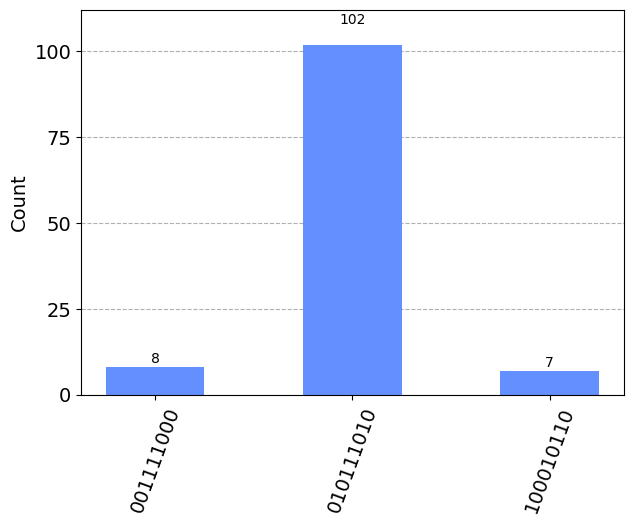

In [251]:
backend = Aer.get_backend('aer_simulator')
job = execute(circuit, backend, shots=1024)
result = job.result()
counts = result.get_counts(circuit)
sorted_counts = dict(sorted(counts.items(), key= lambda item: item[1], reverse =True))
top_three = dict(list(sorted_counts.items())[:3])
plot_histogram(top_three)

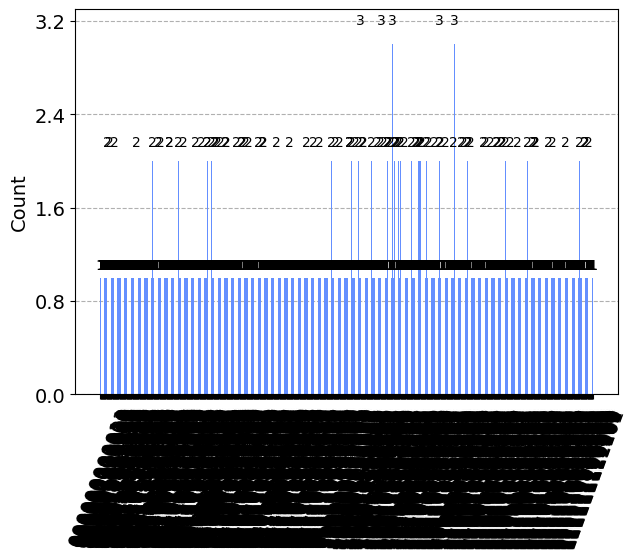

In [245]:
plot_histogram(counts)

In [211]:
print("Expected: ")
for solution in solutions:
    print(solution)
    display_nonogram(solution, rows, columns)

aer_sim = Aer.get_backend('aer_simulator')       
result = execute(qc, aer_sim, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)

Expected: 


NameError: name 'solutions' is not defined

# Unit tests

## Diffusion

In [ ]:
!pytest

In [ ]:
@pytest.fixture
def n_qubits():
    return 3

@pytest.fixture
def q():
    return QuantumRegister(n_qubits(), 'q')

@pytest.fixture
def c(q):
    return QuantumCircuit(q)

def test_apply_diffusion(c, q, n_qubits):
    apply_diffusion(c,q)
    assert len(c) == 10*n_qubits-4
    expected_gates = ['h','x','h','mcx','h','x','h','q','h','x','h','mcx','h','x','h','q','h','x','h','mcx','h','x','h','q','h','x','h','mcx','h','x','h','q']
    for i, gates in enumerate(expected_gates):
        assert c.data[i][0].name == gate
    assert c.num_qubits == n_qubits

In [ ]:
def test_apply_diffusion_x():
    c = QuantumCircuit(2)
    q = c.qubits
    apply_diffusion(c,q)
    assert c.count_ops()['x'] == 2

In [ ]:
def test_aply_diffusion_mct():
    c = QuantumCircuit(2)
    q = c.qubits
    apply_diffusion(c,q)
    assert c.count_ops()['h'] == 3